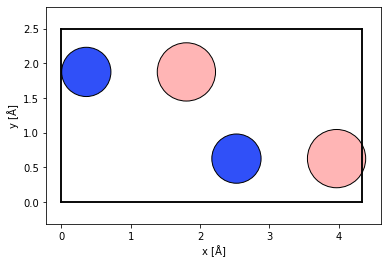

In [1]:
# Create an orthogonal unit cell of hBN using a graphene constructor.

import matplotlib.pyplot as plt
import numpy as np

from ase.lattice.hexagonal import Graphene
from abtem.structures import orthogonalize_cell
from abtem.visualize import show_atoms

structure = Graphene(symbol='C', latticeconstant={'a':2.5, 'c':12},
                      size=(1,1,1))
structure.pbc = True
structure[0].symbol='B'
structure[1].symbol='N'

# Orthogonalize cell
atoms = orthogonalize_cell(structure)
atoms.rotate(90, 'z', rotate_cell=True)
atoms.cell=[4.3284, 2.499, 12]
atoms.center()

show_atoms(atoms);

In [2]:
# Run a cheap DFT calculation to get the electrostatic potential.
# Takes less than a minute and requires less than 1 GB of memory.

from gpaw import GPAW, FermiDirac, PW

gpaw = GPAW(mode=PW(350), basis='dzp', xc='PBE', 
            occupations=FermiDirac(0.01), kpts=(3,6,1),
            txt=None) # Remove to not suppress GPAW text output.

atoms.set_calculator(gpaw)
atoms.get_potential_energy()

gpaw.write('hBN_k36.gpw');

In [3]:
from gpaw import restart

atoms, gpaw = restart('hBN_k36.gpw', txt=None)

In [5]:
# Create DFT and independent atom potentials for the system.
# NOTE: requires the optional GPAW installation to run!

from abtem import *
from abtem.potentials import Potential
from abtem.dft import GPAWPotential
from abtem.transfer import scherzer_defocus

potential_dft = GPAWPotential(gpaw, sampling=.04)
potential_iam = Potential(atoms, gpts=potential_dft.gpts, sampling=.04)

# Create near-ideal scanning probe.
alpha = 31.5
E = 80000
Csval = 1e5
df = scherzer_defocus(E, Csval)

probe = Probe(energy=E, semiangle_cutoff=alpha, defocus=df, Cs=Csval)

# Match probe grid to the DFT potential grid.
probe.grid.match(potential_dft)

# Scan the entire cell at slightly below Nyquist sampling.
gridscan = GridScan(start=[0, 0], end=[atoms.cell[0][0], atoms.cell[1][1]], sampling=probe.ctf.nyquist_sampling*0.9)

# Define bright and dark field annular detectors.
bf_detector = AnnularDetector(inner=0, outer=alpha/2)
adf_detector = AnnularDetector(inner=3*alpha, outer=4*alpha)

In [6]:
# Running the multislice simulation for both potentials takes less than a minute.
measurements_iam = probe.scan(gridscan, [bf_detector, adf_detector], potential_iam)
measurements_dft = probe.scan(gridscan, [bf_detector, adf_detector], potential_dft)

Scan:   0%|          | 0/135 [00:00<?, ?it/s]

Potential:   0%|          | 0/24 [00:00<?, ?it/s]

Scan:   0%|          | 0/135 [00:00<?, ?it/s]

Potential:   0%|          | 0/27 [00:00<?, ?it/s]

In [7]:
# We tile the measurements to plot larger fields of view,
# and then plot diffractograms of the bright field measurements.
# Due to the Nyquist sampling, the measurements can also be interpolated 
# down to the potential spacing without artifacts. 

bf_iam = measurements_iam[bf_detector].interpolate(0.04).tile((2,3))
adf_iam = measurements_iam[adf_detector].interpolate(0.04).tile((2,3))
diff_iam = measurements_iam[bf_detector].tile((2,3)).diffractograms()

bf_dft = measurements_dft[bf_detector].interpolate(0.04).tile((2,3))
adf_dft = measurements_dft[adf_detector].interpolate(0.04).tile((2,3))
diff_dft = measurements_dft[bf_detector].tile((2,3)).diffractograms()

In [8]:
# Create line profiles over the B and N atoms, and diffractions spots.

from abtem.measure import interpolate_line

rep = atoms.copy()
rep *=((2,3,1))

x1 = (rep[4].position[0]+rep[5].position[0])/2
x2 = (rep[16].position[0]+rep[17].position[0])/2
y = rep[19].position[1]

xc = (x1, x2)
yc = (y, y)
dxc = (-1,1)
dyc = (1/2.5,1/2.5)

start = (x1, y)
dstart = (2.5, 1/2.5)
end = (x2,y)
dend = (-1/2.5, 1/2.5)

l_bf_iam = interpolate_line(bf_iam, start, end)
l_adf_iam = interpolate_line(adf_iam, start, end)
l_diff_iam = interpolate_line(diff_iam, dstart, dend, sampling=0.04)

l_bf_dft = interpolate_line(bf_dft, start, end)
l_adf_dft = interpolate_line(adf_dft, start, end)
l_diff_dft = interpolate_line(diff_dft, dstart, dend, sampling=0.04)

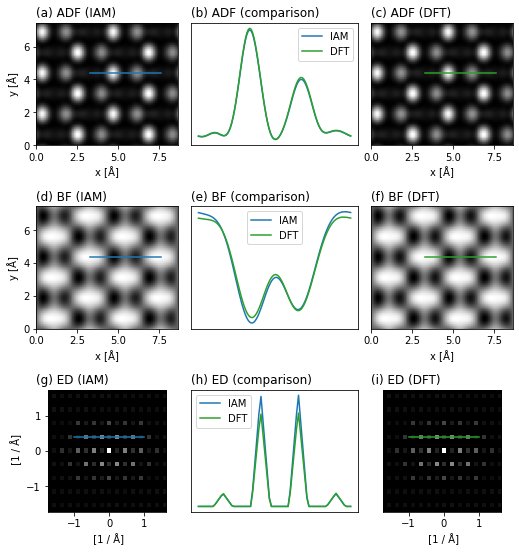

In [15]:
# Plot a figure of the results.

from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(9,9), gridspec_kw={'hspace': 0.5, 'wspace': 0.0})

adf_iam.show(ax=axes[0,0])
adf_dft.show(ax=axes[0,2])
l_adf_iam.show(ax=axes[0,1], color='tab:blue', label='IAM')
l_adf_dft.show(ax=axes[0,1], color='tab:green', label='DFT')
axes[0,0].plot(xc, yc, 'tab:blue')
axes[0,2].plot(xc, yc, 'tab:green')

axes[0,0].set_title('(a) ADF (IAM)', x=0, ha='left')
axes[0,1].set_title('(b) ADF (comparison)', x=0, ha='left')
axes[0,2].set_title('(c) ADF (DFT)', x=0, ha='left')
axes[0,2].yaxis.set_visible(False)

bf_iam.show(ax=axes[1,0])
bf_dft.show(ax=axes[1,2])
l_bf_iam.show(ax=axes[1,1], color='tab:blue', label='IAM')
l_bf_dft.show(ax=axes[1,1], color='tab:green', label='DFT')
axes[1,0].plot(xc, yc, 'tab:blue')
axes[1,2].plot(xc, yc, 'tab:green')

axes[1,0].set_title('(d) BF (IAM)', x=0, ha='left')
axes[1,1].set_title('(e) BF (comparison)', x=0, ha='left')
axes[1,2].set_title('(f) BF (DFT)', x=0, ha='left')
axes[1,2].yaxis.set_visible(False)

diff_iam.show(ax=axes[2,0], power=0.08)
diff_iam.show(ax=axes[2,2], power=0.08)
axes[2,0].plot(dxc, dyc, color='tab:blue')
axes[2,2].plot(dxc, dyc, color='tab:green')
l_diff_iam.show(ax=axes[2,1], color='tab:blue', label='IAM')
l_diff_dft.show(ax=axes[2,1], color='tab:green', label='DFT')

axes[2,0].set_title('(g) ED (IAM)', x=-0.1, ha='left')
axes[2,1].set_title('(h) ED (comparison)', x=0, ha='left')
axes[2,2].set_title('(i) ED (DFT)', x=-0.1, ha='left')
axes[2,2].yaxis.set_visible(False)

for ax in (axes[0,1], axes[1,1], axes[2,1]):
    ax.set_yticks([])
    ax.xaxis.set_visible(False)
    ax.legend()
    
plt.savefig('hBN.pdf')